# Time Dependent Quantum Mechanics

In Lecture 10, we developed some solutions for the stationary Schrödinger equation. We solved the harmonic oscillator or the particle in a box model. All of this did not give any dynamics of particles in potentials but rather a static picture. Today we would like to consider the time dependent Schrödinger equations which yields the dynamics of the system. We will develop a solution based on Fourier transforms, as we still have to practice that a bit.

In [234]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.constants import *
from scipy.sparse import diags
from scipy.sparse.linalg import eigsh
from scipy.fftpack import fft,ifft
from time import sleep,time

from ipycanvas import MultiCanvas, hold_canvas,Canvas


%matplotlib inline
%config InlineBackend.figure_format = 'retina'

# default values for plotting
plt.rcParams.update({'font.size': 16,
                     'axes.titlesize': 18,
                     'axes.labelsize': 16,
                     'axes.labelpad': 14,
                     'lines.linewidth': 1,
                     'lines.markersize': 10,
                     'xtick.labelsize' : 16,
                     'ytick.labelsize' : 16,
                     'xtick.top' : True,
                     'xtick.direction' : 'in',
                     'ytick.right' : True,
                     'ytick.direction' : 'in',}) 

## Time dependent Schrödinger equation

The time dependent Schrödinger equation is given by 

\begin{equation}
-i\hbar\frac{\partial \Psi}{\partial t}=-\frac{\hbar^2}{2m}\nabla^2 \Psi + V(x)\Psi
\end{equation}

in 3 dimensions. We have already shortly mentioned this equation in 1 dimension

\begin{equation}
-i\hbar\frac{\partial \Psi(x,t)}{\partial t} = \left ( \frac{-\hbar^2 }{2m}\frac{\partial^2}{\partial x^2}+V(x,t) \right ) \Psi(x,t)
\end{equation}

during the last lecture. We are using the 1-dimensional equation today again to study the dynamics of a particle in a box and the tunneling of a particle. To do so, we first have a look at wavepackets.

## Wavepackets

As particles are typically localized objects we need to construct a wavpacket. A wavepackets can be constructed from a superposition of plane waves. A wavepacket can be constructed from a superposition of plane waves with different wavenumber $k$ or different frequency $\omega$. We write down examples only for the wavenumber, but equivalently, they may be developed for the frequency as well. 

\begin{equation}
\Psi(x)=A\int\limits_{+\infty}^{-\infty}\phi(k)e^{ikx}e^{-i\omega t}dk
\end{equation}

The function $\phi(k)$ gives the amplitude of the wavefunction with the value $k$ in the wavepacket. If for example only one wave at $k_0$ is contributing to the wavepacket, then the function $\phi(k_0)=1$ but for all other $k$ this function is zero. Therefore the integral results only in a single plane wave.


### Demonstration of superposition of plane waves

The code below just shows how waves of different wave vector can be combined to result in a wave packet, i.e. n object that is localized in space. This is nothing else then a Fourier decomposition of a spatially extended object.

In [409]:
wavelength=1e-10 # wavelenth of the matter wave in Angstroem
k0=2*np.pi/wavelength # wavevector of the matter wave
dk=k0/40 # intervall of the matter wave 
electron_mass=9.10938356e-31
hbar=1.0545718e-34

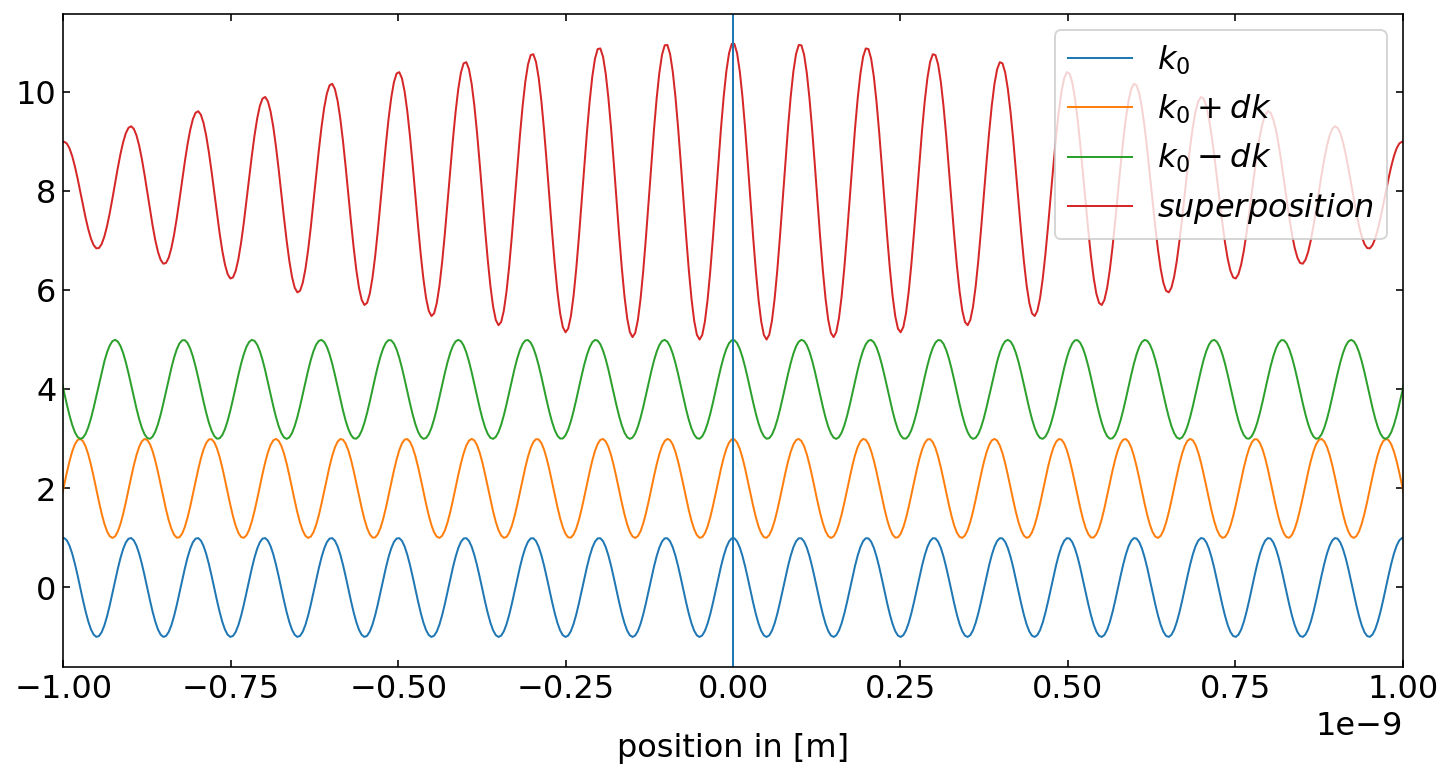

In [410]:
plt.figure(figsize=(12,6))

x=np.linspace(-2e-9,2e-9,1000)
k=k0
t=0
frequency=hbar*k**2/(2*electron_mass)
h=np.exp(1j*(k*x-frequency*t))
a=np.copy(h)

plt.plot(x,np.real(h),label='$k_0$')

k=k0+dk
frequency=hbar*k**2/(2*electron_mass)
h=np.exp(1j*(k*x-frequency*t))
a+=h
plt.plot(x,np.real(h)+2,label='$k_0+dk$')

k=k0-dk
frequency=hbar*k**2/(2*electron_mass)
h=np.exp(1j*(k*x-frequency*t))
a+=h
plt.plot(x,np.real(h)+4,label='$k_0-dk$')


plt.plot(x,np.real(a)+8,label='$superposition$')
plt.axvline(x=0)
plt.legend(loc='upper right')
plt.xlim(-1e-9,1e-9)
plt.xlabel('position in [m]')
plt.show()

### Wavepacket

If the distribution of amplitudes $\phi(k)$ extends over a larger region, i.e. from $k_{0}-\Delta k/2$ to $k_{0}+\Delta k/2$ with equal amplitudes over a whole range $\phi(k)={\rm const.}$ our first wavepacket arises. For matter waves we have to take into account that $\omega$ is a function of the wavevector as well.

\begin{equation}
\omega=\frac{\hbar k^{2}}{2m}
\end{equation}

To calculate the shape of the wavepacket we approximate the above dispersion relation by

\begin{equation}
\omega=\omega_0+\frac{\partial \omega}{\partial k}(k-k_{0})
\end{equation}

which replaces the above dispersion relation by an approximate linear one. 


As a final result we obtain the wavepacket 

\begin{equation}
\Psi(x,t)=2A\frac{\sin\left(x-\frac{\partial \omega}{\partial k}t\right)\frac{\Delta k}{2}}{x-\frac{\partial \omega}{\partial k}t}e^{i(k_0x-\omega_0 t)}
\end{equation}

Obviously the wavepacket has an underlying plane wave which is the rightmost exponential factor. The fator in front of the plane wave defines the envelope of the wavepacket. The envelope appears through the superposition of all plane waves. It propagates with the group velocity $v_{g}=\partial \omega/\partial k$, while the plane wave propagates with the phase velocity $v_{ph}=\omega_{0}/k_0$, which can be different than the group velocity.




### Wavepacket with rectangular amplitude

The wavepacket above had just constant amplitudes over a range of wavenumbers. While we have an analytical function for this type of wave, we just program a function to show that the superposition works as well.

In [411]:
# matter wave packet with a frequency that scales with the square of the wave vector
def matter_wave_packet(x,t):
    h=0
    N=100
    for k in np.linspace(k0-dk,k0+dk,N):
        frequency=hbar*k**2/(2*electron_mass)
        h+=np.exp(1j*(k*x-frequency*t))/N        
                
    return(h)

The plot below now shows the magnitude square of the wavefunction, i.e. $|\Psi |^2$. You may recognize the side lobes besides the main peak. The whole distribution is reminiscent of the diffraction pattern of a single slit in the far field as tackeled also in our lectures on electromagnetic waves. You may want to think about this similarity a bit longer. 

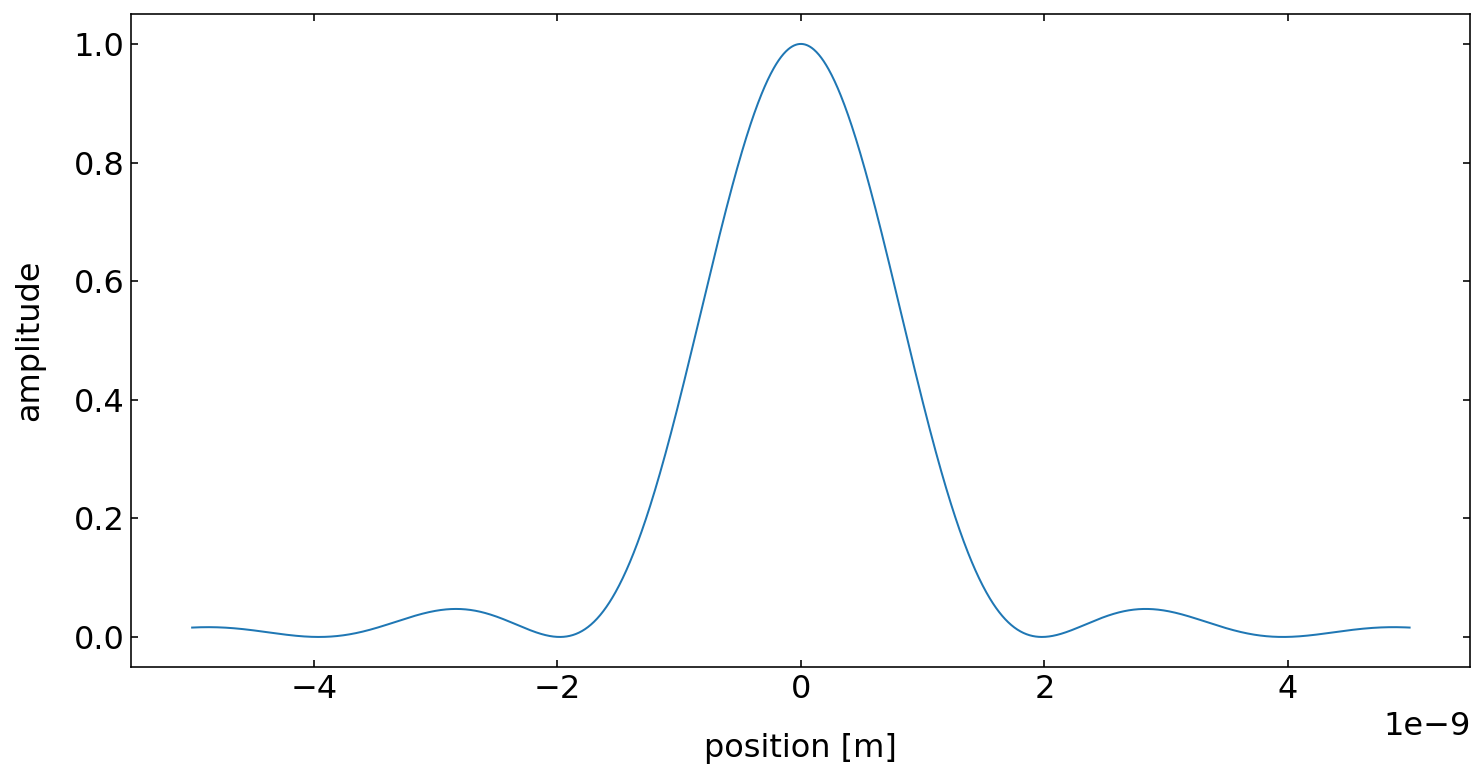

In [412]:
fig = plt.figure(1,figsize=(12,6))

x=np.linspace(-5e-9,5e-9,2000)
plt.plot(x,np.abs(matter_wave_packet(x,0))**2)
plt.xlabel(r'position [m]',fontsize=16)
plt.ylabel(r'amplitude',fontsize=16)
#plt.tick_params(labelsize=10)
plt.show()

### Gaussian Wave Packet

We next create a Gaussian wave packet, which means that the amplitudes $\phi(k)$ of the interfering plane waves follow a Gaussian distribution. The result is then also a Gaussian function for the spatial distribution. 

In [413]:
def gauss_wave_packet(x,t):
    h=0
    for k in np.linspace(k0-5*dk,k0+5*dk,1000):
        frequency=hbar*k**2/(2*electron_mass)
        sigma=np.sqrt(2)*dk
        h+=np.exp(-((k-k0)/sigma)**2)*np.exp(1j*(k*x-frequency*t))        
    return(h)

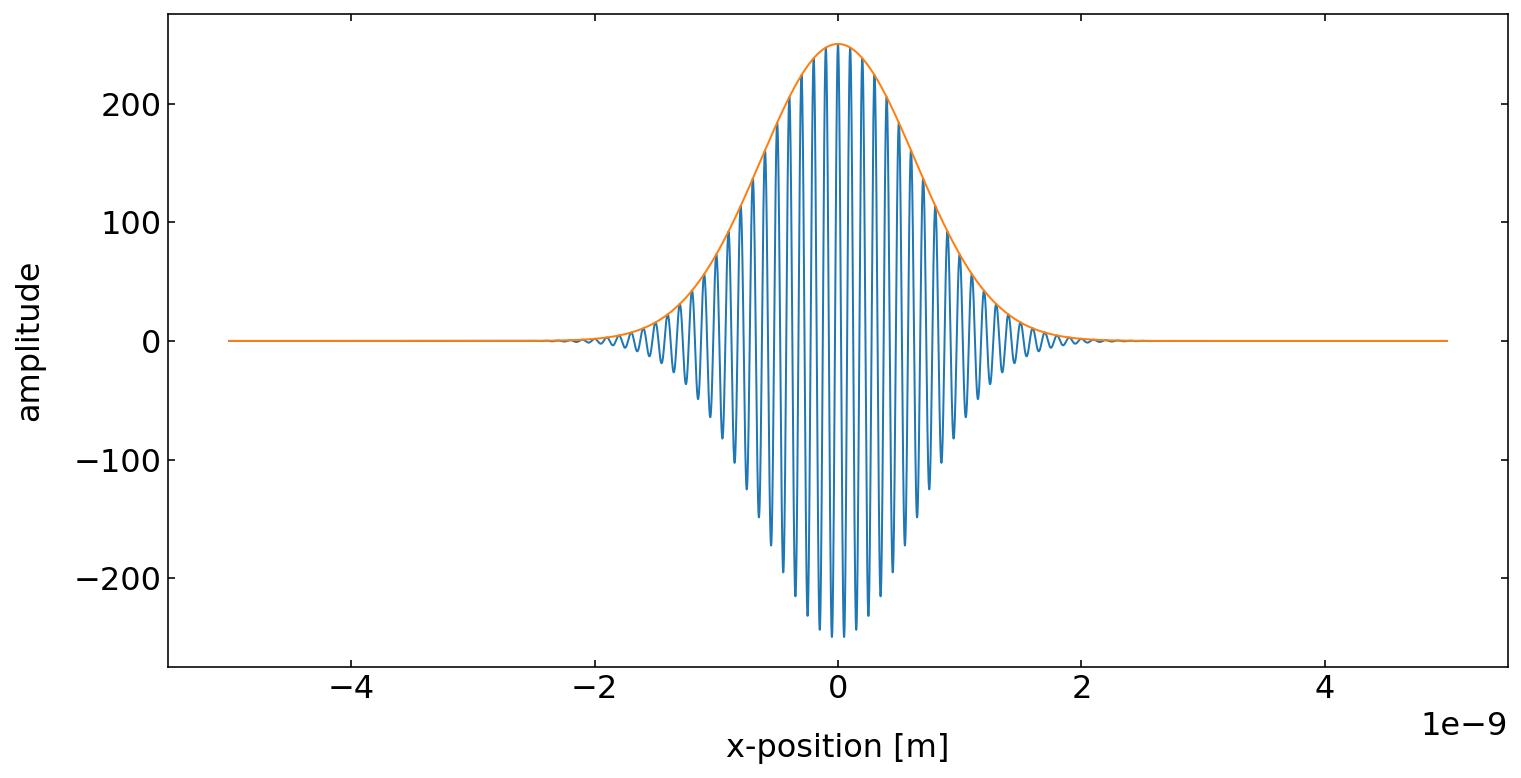

In [421]:
fig = plt.figure(1,figsize=(12,6))

x=np.linspace(-5e-9,5e-9,10000)
plt.plot(x,np.real(gauss_wave_packet(x,0)))
plt.plot(x,np.abs(gauss_wave_packet(x,0)))
plt.xlabel(r'x-position [m]',fontsize=16)
plt.ylabel(r'amplitude',fontsize=16)

plt.show()

## Time evolution of a Gaussian Wavepacket

We would like to plot in the next sections the time evolution of the wavefunction. Of course, we want to see the function developing live over time in a nice diagram. 
We could use the `matplotlib` `animate` method, which is commonly used to create a movie file that is later embedded in the notebook. Here we want to take a different route. We use `matplotlib` to generate the plot. We store the image data for the plot in an numpy array, which we then show with the help of our `ipycanvas` module. When calculations are not taking to long, this is a good way to animate in real time.

In [425]:
## setup the canvas
canvas = Canvas(width=800, height=200,sync_image_data=False)
display(canvas)

Canvas(height=200, width=800)

The next lines do the magic here. You see that there is essentially a normal `matplotlib` plotting in the first lines. The special lines are 

~~~
plt.draw()
background = fig.canvas.copy_from_bbox(ax.bbox)
points=ax.plot(x*1e9,np.abs(gauss_wave_packet(x,t))**2)[0]
plt.close() 
~~~

which draws the diagram without the data into the buffer. We store that buffer as the background  with `fig.canvas.copy_from_bbox(ax.bbox)`, because it is everytime the same. The third line obtains the data point list as a matplotlib object. 
This list can be later updated with new data for the animation. Finally, we close the figure with `plt.close()` to prevent extra drawing below the cell. 

In [423]:
x=np.linspace(0,20e-9,1000)

fig, ax = plt.subplots(1,1,figsize=(10,3))
plt.xlim(0,20)
plt.ylim(0,100000)

plt.xlabel('x [nm]')
plt.ylabel(r'$\Psi(x,t)$')
plt.tight_layout()  


plt.draw()
background = fig.canvas.copy_from_bbox(ax.bbox)
points=ax.plot(x*1e9,np.abs(gauss_wave_packet(x,t))**2)[0]
plt.close() 




The animation is then done by a for loop through time calculating the new wavefunction data and supplying it to the `points` object as new data. In detail it looks this way.

In [424]:
for t in np.linspace(0,5e-15,100):
    fig.canvas.restore_region(background) ## restore the background we have saved before
    ax.draw_artist(points) ## draw the plot with the data points
    points.set_data(x*1e9,np.abs(gauss_wave_packet(x,t))**2) ## modify the data in the points object with the new coordinates coming from the wavefunction
    
    fig.canvas.blit(ax.bbox) ## copy everything into the figure canvas
    
    X = np.array(fig.canvas.renderer.buffer_rgba()) ## obtain the image representing the plot as a color image with red, green, blue and alpha pixel values
   
    ## this is now our previous ipycanvas image drawing 
    with hold_canvas(canvas): 
        canvas.clear()
        canvas.put_image_data(X)
        sleep(0.02)